In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
from src import utils
from src import ps
import numpy as np

In [25]:
lines = utils.load_data(1)
N, M, H, b, tin, tax, sec = utils.parse_data(lines)

In [4]:
import time
start = time.time()

end = time.time()
print(start - end)

0.0


In [26]:
ss = ps.Schedule()
ss.load_data(1)

In [6]:
def first_assignment(index):
    global M, H, tin, sec
    
    _tb = np.zeros(shape=(M))
    _ts = np.zeros(shape=(H))
    _tin = np.array(tin[index])
    _sec = np.array(sec[index])
    
    for j in range(1, M):
        if j == 0:
            _tb[0] = 0
        
        else:
            _tb[j] = _tb[j - 1] + _tin[j - 1]
            
    for h, j in enumerate(b):
        _ts[h] = _tb[j]
        _tb[j:] += _sec[b.index(j)]
    
    _tf = _tb[M - 1] + _tin[M - 1]
    return _tb, _ts, _tf

In [27]:
tb0, ts0, tf0 = first_assignment(0)

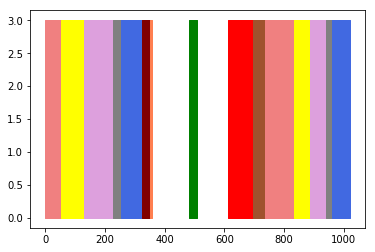

In [28]:
fig, ax = plt.subplots()

ax.broken_barh(ss.compute_Vb(tb0, ts0, tf0), yrange=(0,3), color=co)


In [7]:
%timeit first_assignment(0)

53 µs ± 1.87 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [38]:
def assign_new_request(tb_prev, ts_prev, tf_prev, index, compute_max):
    global M, sec, tin, tax
    
    _tb = np.zeros(shape=(M))
    _ts = np.zeros(shape=(H))
    _tin = np.array(tin[index])
    _sec = np.array(sec[index])
    _tax = np.array(tax[index])
    _b = np.array(b)
    
    for j in range(M):
        
        if j == 0:
            _tb[0] = tb_prev[1]
        
        elif j < M - 1:
            _tb[j] = max(_tb[j - 1] + _tin[j - 1], tb_prev[j+1])
        else:
            _tb[j] = max(_tb[j - 1] + _tin[j - 1], tf_prev)
    
    for h, j in enumerate(b):
        j -= 1
        
        if j == 0:
            _tb[j:] -= _tb[j] - ts_prev[h]
        elif h > 0:
            _tb[j:] -= min(_tb[j] - (_tb[j - 1] + _tin[j - 1]), _tb[j] - ts_prev[h], _tb[j] - _ts[h - 1] - _sec[h - 1])
        else:
            _tb[j:] -= min(_tb[j] - (_tb[j - 1] + _tin[j - 1]), _tb[j] - ts_prev[h])
            
        _ts[h] = _tb[j] + _tin[j]
        delta = tb_prev[j + 1:] - _tb[j:-1]

        if j + 1 in b:  
            _tb[j + 1:] += max(_sec[h], _sec[h] + ts_prev[b.index(j + 1)] - _tb[j + 1], *delta)
        else:
            _tb[j + 1:] += max(_sec[h], _sec[h] + tb_prev[j + 2] - _tb[j + 1], *delta)
    
    _tf = _tb[M - 1] + _tin[M - 1]
          
    new_j = 0
    
    if compute_max:
        for j in range(M):
            
            if j + 1 in b : 
                #doesn´t mean the next j, it is just because b doesn't start at zero         
                h = b.index(j + 1)
                
                if _ts[h] > _tax[j] + _tb[j]:
                    shift = _ts[h] - _tb[j] - _tax[j]
                    _tb[new_j:j + 1] += shift
                    _ts[h] += shift
                
                new_j = j
                
            elif j < M - 1 and _tb[j + 1] > _tax[j] + _tb[j]:
                shift = _tb[j + 1] - _tb[j] - _tax[j]
                _tb[new_j:j + 1] += shift
                _ts[h] += shift
                
            elif j == M - 1 and tf_prev > _tb[j]:
                shift = tf_prev - _tb[j]
                _tb[new_j:] += shift
                _ts[h] += shift
                _tf += shift
            print(_tb, _ts, _tf)     
    return _tb, _ts, _tf
            

In [33]:
def assign_new_request(tb_prev, ts_prev, tf_prev, index, compute_max):
    global M, sec, tin, tax
    
    _tb = np.zeros(shape=(M))
    _ts = np.zeros(shape=(H))
    _tin = np.array(tin[index])
    _sec = np.array(sec[index])
    _tax = np.array(tax[index])
    _b = np.array(b)
    
    for j in range(M):
        
        if j == 0:
            _tb[0] = tb_prev[1]
        
        elif j < M - 1:
            _tb[j] = max(_tb[j - 1] + _tin[j - 1], tb_prev[j+1])
        else:
            _tb[j] = max(_tb[j - 1] + _tin[j - 1], tf_prev)
    
    for h, j in enumerate(b):
        j -= 1
        
        if j == 0:
            _tb[j:] -= _tb[j] - ts_prev[h]
        elif h > 0:
            _tb[j:] -= min(_tb[j] - (_tb[j - 1] + _tin[j - 1]), _tb[j] - ts_prev[h], _tb[j] - _ts[h - 1] - _sec[h - 1])
        else:
            _tb[j:] -= min(_tb[j] - (_tb[j - 1] + _tin[j - 1]), _tb[j] - ts_prev[h])
            
        _ts[h] = _tb[j] + _tin[j]
        delta = tb_prev[j + 1:] - _tb[j:-1]

        if j + 1 in b:  
            _tb[j + 1:] += max(_sec[h], _sec[h] + ts_prev[b.index(j + 1)] - _tb[j + 1], *delta)
        else:
            _tb[j + 1:] += max(_sec[h], _sec[h] + tb_prev[j + 2] - _tb[j + 1], *delta)
    
    _tf = _tb[M - 1] + _tin[M - 1]
          
        
    if compute_max:
        for j in range(M):
            
            if j + 1 in b : 
                #doesn´t mean the next j, it is just because b doesn't start at zero         
                h = b.index(j + 1)
                
                if _ts[h] > _tax[j] + _tb[j]:
                    shift = _ts[h] - _tb[j] - _tax[j]
                    _tb[:j + 1] += shift
                    _ts[h] += shift
               
            elif j < M - 1 and _tb[j + 1] > _tax[j] + _tb[j]:
                shift = _tb[j + 1] - _tb[j] - _tax[j]
                _tb[:j + 1] += shift
                _ts[_b < j + 1] += shift
                
            elif j == M - 1 and tf_prev > _tb[j]:
                shift = tf_prev - _tb[j]
                _tb += shift
                _ts += shift
                _tf += shift
            print(_tb, _ts, _tf)     
    return _tb, _ts, _tf
            

In [39]:
tb1, ts1, tf1 = assign_new_request(tb0, ts0, tf0, True, 1)

[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.] 1342.0
[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.] 1342.0
[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.] 1342.0
[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.] 1342.0
[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.] 1342.0
[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.] 1342.0
[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.] 1342.0
[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.] 1342.0
[  53.  138.  225.  299.  384.  447.  523.  705.  841.  906.  990. 1058.
 1131. 1194. 1266.] [596. 747.]

[Text(0,0,'Pedido 1'), Text(0,0,'Pedido 2')]

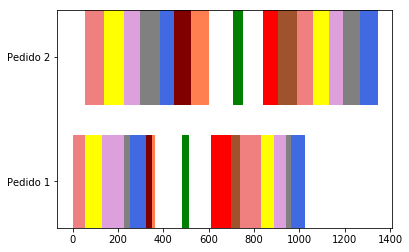

In [40]:
fig, ax = plt.subplots()

ax.broken_barh(ss.compute_Vb(tb0, ts0, tf0), yrange=(0,3), color=co)
ax.broken_barh(ss.compute_Vb(tb1, ts1, tf1), yrange=(4,7), color=co)

ax.set_ylim(0, 7)

ax.set_yticks([1.5, 5.5])
ax.set_yticklabels(['Pedido 1', 'Pedido 2'])

In [187]:
from src import ps

In [215]:
ss = ps.Schedule()
ss.load_data(11)

In [50]:
tb, ts, tf, order = ss.assign_all(1, 0)

In [216]:
best = 10000000
start = time.time()
ti = []
fo = []
for i in range(ss.N):
    tb, ts, tf, order = ss.assign_all(i, 0)
    if max(tf) < best:
        best = max(tf).copy()
        clock = time.time()
        ti.append(clock - start)
        fo.append(best)
        tb_opt, ts_opt, tf_opt, order_opt = tb.copy(), ts.copy(), tf.copy(), order.copy()
        print(ti[-1], fo[-1])

0.15001964569091797 3332.0
0.33031344413757324 3274.0
0.5026693344116211 3251.0
1.0202488899230957 3187.0
3.1989152431488037 3169.0


In [214]:
ps.write_output(tb_opt, ts_opt, tf_opt, fo, ti, 10)

In [147]:
import matplotlib.pyplot as plt
co = ['lightcoral', 'yellow', 'plum', 'grey', 'royalblue', 'maroon', 'coral', 'g', 'red', 'sienna']

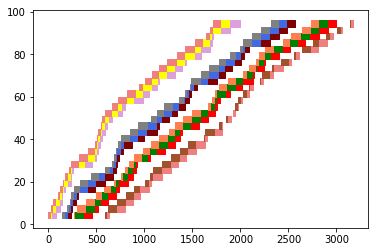

In [217]:
fig, ax = plt.subplots()
pp=0
for i in order_opt:
    pp += 3
    ax.broken_barh(ss.compute_Vb(tb_opt[i], ts_opt[i], tf_opt[i]), yrange=(pp,3), color=co)


In [146]:
tb_opt[14], ts_opt[14], tf_opt[14]

(array([2946., 3041., 3139., 3223., 3304., 3402., 3497., 3585., 3913.,
        4010., 4106.]), array([3677.]), 4186.0)

In [195]:
_vv = ss.compute_Vb(tb_opt[14], ts_opt[14], tf_opt[14]); _vv

[(379.0, 30.0),
 (409.0, 92.0),
 (501.0, 48.0),
 (799.0, 13.0),
 (812.0, 9.0),
 (821.0, 7.0),
 (1076.0, 11.0),
 (1199.0, 45.0),
 (1700.0, 8.0)]

In [145]:
ss.compute_Vb(tb_opt[14], ts_opt[14], tf_opt[14])

[(2946.0, 95.0),
 (3041.0, 98.0),
 (3139.0, 84.0),
 (3223.0, 81.0),
 (3304.0, 98.0),
 (3402.0, 95.0),
 (3497.0, 88.0),
 (3585.0, 92.0),
 (3913.0, 97.0),
 (4010.0, 96.0),
 (4106.0, 80.0)]

In [190]:
sum([tb1[b[h]] - ts1[h] for h, j in enumerate(ts1)])

203.0

In [185]:
tb1, ts1

(array([  53.,  138.,  225.,  299.,  384.,  447.,  523.,  705.,  841.,
         906.,  990., 1058., 1131., 1194., 1266.]), array([596., 747.]))